In [82]:
import pandas as pd
import numpy as np

import seaborn as sns
sns.set_theme(style="darkgrid")

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

import os

In [48]:
from itertools import cycle
from tqdm.notebook import tqdm

from linreg.linear_regression import LinearRegression as myLinReg
from linreg.optimizers import *
from linreg.metrics import *

In [38]:
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

In [4]:
plt.rcParams["axes.labelsize"] = 16.
plt.rcParams["xtick.labelsize"] = 14.
plt.rcParams["ytick.labelsize"] = 14.
plt.rcParams["legend.fontsize"] = 12.
plt.rcParams["figure.figsize"] = [15., 6.]
SEED = 42

In [6]:
os.chdir('/home/sergey/Documents/homeworks/linreg_spbu_hw')

## Читаем исходные данные

In [4]:
df_raw = pd.read_csv("data/2016_01.csv", sep=",")
print(df_raw.shape)
df_raw.head()

(434354, 29)


,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,...,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
0,2016,1,5,2,AA,N3EKAA,238,MIA,DCA,1415,...,0.0,150.0,144.0,126.0,919.0,15.0,0.0,0.0,0.0,0.0
1,2016,1,6,3,AA,N3KUAA,238,MIA,DCA,1415,...,0.0,150.0,148.0,128.0,919.0,NaN,NaN,NaN,NaN,NaN
2,2016,1,7,4,AA,N3AVAA,238,MIA,DCA,1415,...,0.0,150.0,148.0,123.0,919.0,18.0,0.0,0.0,0.0,6.0
3,2016,1,8,5,AA,N3DSAA,238,MIA,DCA,1415,...,0.0,150.0,171.0,116.0,919.0,0.0,0.0,52.0,0.0,0.0
4,2016,1,9,6,AA,N3DFAA,238,MIA,DCA,1415,...,0.0,150.0,158.0,121.0,919.0,NaN,NaN,NaN,NaN,NaN


## Смотрим на столбцы и пропуски в данных.  
### Удаляем столбцы, содержащие информацию, которой мы не можем располагать до взлета самолета.

In [5]:
df_raw.isna().sum()

YEAR                        0
MONTH                       0
DAY_OF_MONTH                0
DAY_OF_WEEK                 0
OP_UNIQUE_CARRIER           0
TAIL_NUM                    0
OP_CARRIER_FL_NUM           0
ORIGIN                      0
DEST                        0
CRS_DEP_TIME                0
DEP_TIME                    0
DEP_DELAY                   0
TAXI_OUT                  127
TAXI_IN                   434
CRS_ARR_TIME                0
ARR_TIME                  434
ARR_DELAY                1056
CANCELLED                   0
CANCELLATION_CODE      434162
DIVERTED                    0
CRS_ELAPSED_TIME            0
ACTUAL_ELAPSED_TIME      1056
AIR_TIME                 1056
DISTANCE                    0
CARRIER_DELAY          363472
WEATHER_DELAY          363472
NAS_DELAY              363472
SECURITY_DELAY         363472
LATE_AIRCRAFT_DELAY    363472
dtype: int64

In [28]:
data = df_raw[['DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_UNIQUE_CARRIER',
           'ORIGIN', 'DEST', 'DEP_DELAY', 'TAXI_OUT',
           'TAXI_IN', 'CANCELLED', 'CANCELLATION_CODE',
           'DIVERTED', 'CRS_ELAPSED_TIME', 'DISTANCE'
          ]]

### Заполняем пропуски

In [29]:
data['TAXI_OUT'].fillna(data['TAXI_OUT'].mean(), inplace=True)
data['TAXI_IN'].fillna(data['TAXI_IN'].mean(), inplace=True)
data['CANCELLATION_CODE'].fillna('NULL', inplace=True)

<AxesSubplot:>

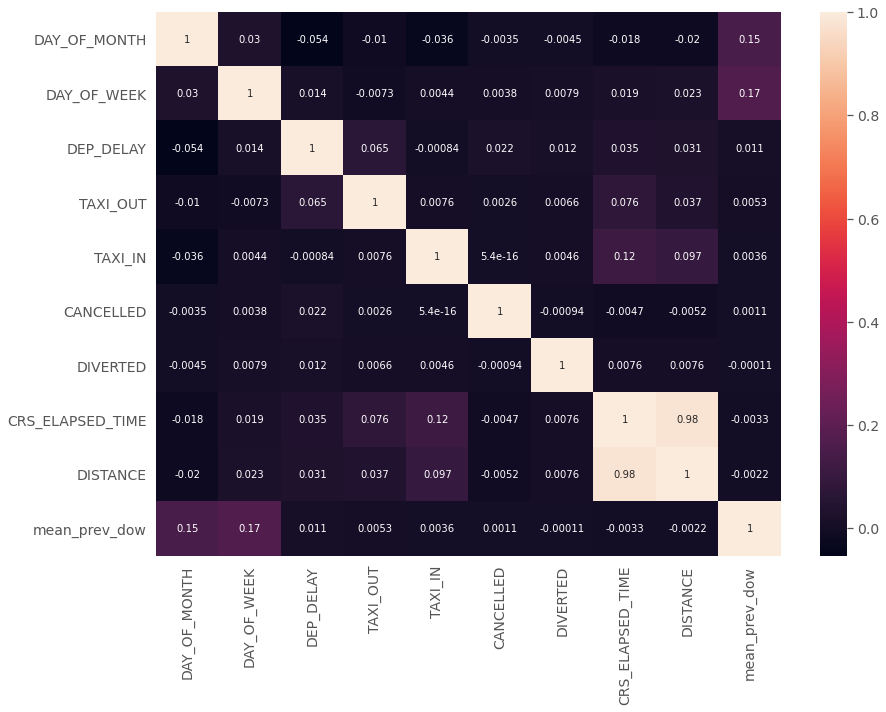

In [157]:
plt.figure(figsize=(14, 10))
sns.heatmap(data.corr(), annot=True)

## Вычленяем новую информацию

In [94]:
data = data.sort_values(by='DAY_OF_MONTH')

In [95]:
data.head()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,ORIGIN,DEST,DEP_DELAY,TAXI_OUT,TAXI_IN,CANCELLED,CANCELLATION_CODE,DIVERTED,CRS_ELAPSED_TIME,DISTANCE
191994,1,5,WN,SEA,LAS,-2.0,8.0,6.0,0.0,NULL,0.0,145.0,867.0
180575,1,5,OO,DEN,LBB,-5.0,11.0,6.0,0.0,NULL,0.0,91.0,456.0
180595,1,5,OO,DEN,STL,0.0,32.0,5.0,0.0,NULL,0.0,130.0,770.0
180622,1,5,OO,ORD,ABQ,68.0,11.0,4.0,0.0,NULL,0.0,200.0,1118.0
180632,1,5,OO,TUL,DEN,-5.0,15.0,9.0,0.0,NULL,0.0,124.0,541.0


In [129]:
data.shape

(434354, 13)

### средняя задержка в текущий день недели (за прошлые недели)

In [123]:
mean_dom_dow = {}
for dom, dow in tqdm(zip(range(1, 32), cycle([5, 6, 7, 1, 2, 3, 4]))):
    mean_dom_dow[dom] = data.query(f'DAY_OF_MONTH < {dom} and DAY_OF_WEEK == {dow}')['DEP_DELAY'].mean()

|          | 0/? [00:00<?, ?it/s]

In [149]:
data['mean_prev_dow'] = data['DAY_OF_MONTH']
data['mean_prev_dow'] = data['mean_prev_dow'].apply(lambda x: mean_dom_dow[x])
data['mean_prev_dow'].fillna(data['DEP_DELAY'].mean(), inplace=True)

In [153]:
data.loc[191994, 'mean_prev_dow']

7.793537068842465

### средняя задержка в предыдущие дни в аэропорту вылета

In [162]:
mean_prev_origin = {}

for origin in tqdm(data['ORIGIN'].unique()):
    mean_prev_origin[origin] = {}
    for day in range(1, 32):
        mean_prev_origin[origin][day] = data.query(
            f'ORIGIN == "{origin}" and DAY_OF_MONTH < {day}'
        )['DEP_DELAY'].mean()

  0%|          | 0/294 [00:00<?, ?it/s]

In [175]:
def mean_prev2value(s, d):
    day, origin = s.split()
    day = int(day)
    return d[origin][day]

In [169]:
data['mean_prev_origin'] = data['DAY_OF_MONTH'].astype(str) + " " + data['ORIGIN']
data['mean_prev_origin'] = data['mean_prev_origin'].apply(lambda x: mean_prev_origin2value(x))
data['mean_prev_origin'].fillna(data['DEP_DELAY'].mean(), inplace=True)

### средняя задержка в предыдущие дни в аэропорту прилета

In [172]:
mean_prev_dest = {}

for dest in tqdm(data['DEST'].unique()):
    mean_prev_dest[dest] = {}
    for day in range(1, 32):
        mean_prev_dest[dest][day] = data.query(
            f'DEST == "{dest}" and DAY_OF_MONTH < {day}'
        )['DEP_DELAY'].mean()

  0%|          | 0/294 [00:00<?, ?it/s]

In [176]:
data['mean_prev_dest'] = data['DAY_OF_MONTH'].astype(str) + " " + data['DEST']
data['mean_prev_dest'] = data['mean_prev_dest'].apply(lambda x: mean_prev2value(x, mean_prev_dest))
data['mean_prev_dest'].fillna(data['DEP_DELAY'].mean(), inplace=True)

### средняя задержка в предыдущие дни у данного перевозчика

In [179]:
mean_prev_carrier = {}

for carrier in tqdm(data['OP_UNIQUE_CARRIER'].unique()):
    mean_prev_carrier[carrier] = {}
    for day in range(1, 32):
        mean_prev_carrier[carrier][day] = data.query(
            f'OP_UNIQUE_CARRIER == "{carrier}" and DAY_OF_MONTH < {day}'
        )['DEP_DELAY'].mean()

  0%|          | 0/12 [00:00<?, ?it/s]

In [182]:
data['mean_prev_carrier'] = data['DAY_OF_MONTH'].astype(str) + " " + data['OP_UNIQUE_CARRIER']
data['mean_prev_carrier'] = data['mean_prev_carrier'].apply(lambda x: mean_prev2value(x, mean_prev_carrier))
data['mean_prev_carrier'].fillna(data['DEP_DELAY'].mean(), inplace=True)

### средняя задержка в предыдущие дни у данного самолета

In [200]:
data['TAIL_NUM'] = df_raw['TAIL_NUM']

In [201]:
mean_prev_tail = {}

for tail in tqdm(data['TAIL_NUM'].unique()):
    mean_prev_tail[tail] = {}
    for day in range(1, 32):
        mean_prev_tail[tail][day] = data.query(
            f'TAIL_NUM == "{tail}" and DAY_OF_MONTH < {day}'
        )['DEP_DELAY'].mean()

  0%|          | 0/4236 [00:00<?, ?it/s]

In [202]:
data['mean_prev_tail'] = data['DAY_OF_MONTH'].astype(str) + " " + data['TAIL_NUM']
data['mean_prev_tail'] = data['mean_prev_tail'].apply(lambda x: mean_prev2value(x, mean_prev_tail))
data['mean_prev_tail'].fillna(data['DEP_DELAY'].mean(), inplace=True)

In [10]:
data = pd.read_csv('data/preproc.csv', index_col='Unnamed: 0')

In [11]:
data.head()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,ORIGIN,DEST,DEP_DELAY,TAXI_OUT,TAXI_IN,CANCELLED,CANCELLATION_CODE,DIVERTED,CRS_ELAPSED_TIME,DISTANCE,mean_prev_dow,mean_prev_origin,mean_prev_dest,mean_prev_carrier,mean_prev_tail,TAIL_NUM
191994,1,5,WN,SEA,LAS,-2.0,8.0,6.0,0.0,NaN,0.0,145.0,867.0,7.793537,7.793537,7.793537,7.793537,7.793537,N385SW
180575,1,5,OO,DEN,LBB,-5.0,11.0,6.0,0.0,NaN,0.0,91.0,456.0,7.793537,7.793537,7.793537,7.793537,7.793537,N593ML
180595,1,5,OO,DEN,STL,0.0,32.0,5.0,0.0,NaN,0.0,130.0,770.0,7.793537,7.793537,7.793537,7.793537,7.793537,N982SW
180622,1,5,OO,ORD,ABQ,68.0,11.0,4.0,0.0,NaN,0.0,200.0,1118.0,7.793537,7.793537,7.793537,7.793537,7.793537,N122SY
180632,1,5,OO,TUL,DEN,-5.0,15.0,9.0,0.0,NaN,0.0,124.0,541.0,7.793537,7.793537,7.793537,7.793537,7.793537,N903SW


## Признаки

In [12]:
def estimate_model(pipline, data_df, target):
    """
    K-fold для модели из коробки
    """
    k_fold = KFold(n_splits=5, shuffle=False)
    r2_scores_train = []
    r2_scores_test = []
    mse_scores_train = []
    mse_scores_test = []
    
    X = data_df.to_numpy()
    y = target.to_numpy()
    for train_index, test_index in k_fold.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        # Train
        pipline.fit(X_train, y_train)

        # r2 score
        r2_scores_train.append(pipline.score(X_train, y_train))
        r2_scores_test.append(pipline.score(X_test, y_test))
        
        # mse
        pred_train = pipline.predict(X_train)
        pred_test = pipline.predict(X_test)
        
        mse_scores_train.append(mean_squared_error(y_train, pred_train))
        mse_scores_test.append(mean_squared_error(y_test, pred_test))

    return r2_scores_train, r2_scores_test, mse_scores_train, mse_scores_test 

In [13]:
def forward_selection(data, target):
    """
    Формируем множество фичей на каждом шаге добавляя ту фичу, которая дает наилучший прирост R^2 on train.
    """
    good_cols = []
    best_r2 = -5.0

    for it in tqdm(range(len(data.columns))):
        new_r2 = -5.0
        new_col = None
        for col in data.columns:
            if col not in good_cols:
                curr_cols = good_cols.copy()
                curr_cols.append(col)
                
                model = LinearRegression()
                _, results, _, _ = estimate_model(model, data[curr_cols], target)
                mean = np.mean(results)
                if mean > new_r2:
                    new_r2 = mean
                    new_col = col
        if new_col:
            good_cols.append(new_col)
            print(f"Iteration: {it}")
            print(f"Columns {new_col} added with R^2 {new_r2:.5f}")
            print(f"Delta= {new_r2 - best_r2}")
            print(f"All cols: {good_cols}\n")
            best_r2 = max(best_r2, new_r2)
            new_col = None
            new_r2 = -5.0

С помощью библиотечных моделей и указанных выше функций был проведен отбор признаков, так как наша собственная модель линейной регрессии сильно уступает библиотечной во времени исполнения. Но почти не уступает в качестве, так что считаем полученные результаты применимыми и к нашей модели.

### выводы о признаках

OneHot encoding для каждого категориального признака незначительно улучшали результаты. Но сильно раздували размерность. Принято решение выбросить все категориальные признаки, так как затраты на время обучения нашей модели не будут оправданы результатом.

Также были сгенерированы квадраты от каждого признака. Результаты и выводы аналогичны с категориальными.

## Cross Validation

In [56]:
def cross_validation(X, y, k=5, optimizer=SgdOptimizer, **kwargs):
    r2_train_list = []
    r2_test_list = []
    mse_train_list = []
    mse_test_list = []
    for i in tqdm(range(k)):
        x_train = [line for j, line in enumerate(X) if j % k != i]
        y_train = [line for j, line in enumerate(y) if j % k != i]
        x_test = X[i::k]
        y_test = y[i::k]
    
        optim=optimizer(**kwargs)
        model = myLinReg(optimizer=optim, verbose=0)
        model.fit(x_train, y_train, iterations=2000)
        
        r2_train_list.append(model.r2_list[-1])
        mse_train_list.append(model.loss_list[-1])
        
        y_pred = model.predict(x_test)
        r2_test_list.append(r2(y_test, y_pred))
        mse_test_list.append(mse(y_test, y_pred))
    
    return r2_train_list, r2_test_list, mse_train_list, mse_test_list

In [35]:
target = data['DEP_DELAY']

In [36]:
train = data.drop(['DAY_OF_WEEK', 'DAY_OF_MONTH', 'CANCELLATION_CODE',
                   'OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST', 'DEP_DELAY', 'TAIL_NUM',
                  ],
                  axis=1)

In [39]:
scaler = MinMaxScaler()
train = scaler.fit_transform(train).tolist()
target = scaler.fit_transform(np.array(target).reshape(-1, 1)).flatten().tolist()

In [97]:
train_part = train[:1000]
target_part = target[:1000]

In [98]:
optimizer = SgdOptimizer(lr=0.1)
model = myLinReg(optimizer=optimizer, verbose=0)
model.fit(train_part, target_part, iterations=2000)

  0%|          | 0/2000 [00:00<?, ?it/s]

<AxesSubplot:>

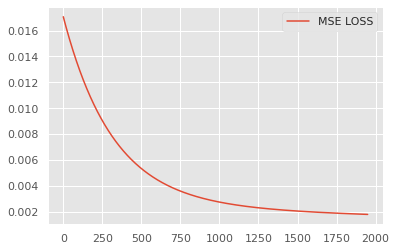

In [99]:
sns.lineplot(x=range(len(model.loss_list[50:])), y=model.loss_list[50:], label='MSE LOSS')

<AxesSubplot:>

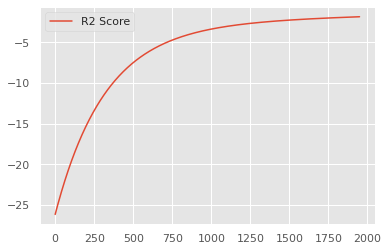

In [100]:
sns.lineplot(x=range(len(model.r2_list[50:])), y=model.r2_list[50:], label='R2 Score')

### regularisation coefs grid search

In [106]:
def alpha_grid(X, y, l1_list=[0.0], l2_list=[0.0], optim=SgdOptimizer, **kwargs):
    coef_list = []
    result_list = []
    for l1 in l1_list:
        for l2 in l2_list:
            r2_scores_train, r2_scores_test, mse_scores_train, mse_scores_test = cross_validation(X, y,
                                                                                                  l1_penalty=l1,
                                                                                                  l2_penalty=l2,
                                                                                                  **kwargs
                                                                                                 )
            coef_list.append((l1, l2))
            result_list.append((r2_scores_train, r2_scores_test, mse_scores_train, mse_scores_test))
    return coef_list, result_list

In [107]:
coef_list, result_list = alpha_grid(train_part, target_part,
                                    l1_list=[0.0, 0.02, 0.04, 0.06, 0.08, 0.1],
                                    l2_list=[0.0, 0.02, 0.04, 0.06, 0.08, 0.1])

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [109]:
pretty_results = []
for r2_scores_train, r2_scores_test, mse_scores_train, mse_scores_test in result_list:
    pretty_results.append((
        (np.mean(r2_scores_train), np.std(r2_scores_train)),
        (np.mean(r2_scores_test), np.std(r2_scores_test)),
        (np.mean(mse_scores_train), np.std(mse_scores_train)),
        (np.mean(mse_scores_test), np.std(mse_scores_test)),
                                        ))

In [114]:
for_df = []
for coefs, results in zip(coef_list, pretty_results):
    for_df.append((coefs[0], coefs[1], results[0][0], results[1][0], results[2][0], results[3][0]))

In [115]:
grid_results = pd.DataFrame(for_df, columns=['l1', 'l2', 'r2_train', 'r2_test', 'mse_train', 'mse_test'])

In [121]:
grid_results.sort_values(by='r2_train', ascending=False).head()

,l1,l2,r2_train,r2_test,mse_train,mse_test
8,0.02,0.04,-0.047284,-0.126549,0.000653,0.000656
5,0.00,0.10,-0.316033,-0.690519,0.000807,0.000810
7,0.02,0.02,-0.626318,-1.294136,0.000985,0.000993
12,0.04,0.00,-0.627699,-1.083887,0.000994,0.000994
4,0.00,0.08,-0.722780,-1.502681,0.001041,0.001045


l1_penalty = **0.02** и l2_penalty = **0.04** дают лучший результат

## Вывод

После проведенного исследования исходных данных, отбора и генерации признаков, перебора параметров линейной регрессии, можно сделать вывод, что наилучший результат дает регрессия с коэфами регуляризации l1_penalty = **0.02** и l2_penalty = **0.04**. Однако такая модель все равно чуть хуже наивной модели, предсказывающей среднее по выборке.